This notebook is an example of how to use the module `evaluation.py` for the evaluation of the output of the neural network.

In [56]:
from evaluation import mc_badness, mc_distance, mc_load_morphemes

In [57]:
# Initialise the language
mc_load_morphemes('Hebrew')

In [58]:
# For a correct encoding, mc_badness() returns 0
mc_badness('W-CLX[TJ:d+K')

0

In [59]:
# For incorrect encodings, mc_badness() returns a positive integer < 262144 = 8**6. 
mc_badness('KCL(/WT')

163840

In [60]:
# With two arguments, mc_badness() also checks the surface form against the input.
# In this example, there is a mismatch: 'BXWR' != 'BWRR'.
mc_badness('W:HAB.AXW.RIJM', 'W-H-BWRR/JM')

8192

In [61]:
# mc_distance() compares two encodings and returns a positive 
# integer < 262144 = 8**6 indicating how far they are apart.
mc_distance('!T=!](H]MT&JQ[', '!T!](H]MMJJQ[')

8194

In [62]:
input_file = 'results_5seq_len_0.0001lr_512embsize_8nhead_transformer_0.1dropout_128_batchsize_5epochs_3beamsize.txt'
output_file = 'results_correct_format.txt'

# optimal_word_idx is index in sequence with most accurate predictions.
optimal_word_idx = 1

class SeqPair:
    """
    Object of which instance contains pair of predicted seqs and true values.
    Class attribute al_pairs collects all instances.
    """
    all_pairs = []
    
    def __init__(self, predicted):
        self.predicted = predicted
        self.true_value = None

In [63]:
# Collect info from output of model.

with open(input_file, 'r') as f:
    for idx, line in enumerate(f):
        if not (line.startswith('Predicted') or line.startswith('Truevalue')):
                continue
        if not idx % 2:
            seq_pair = SeqPair(line.strip('Predicted '))
        else:
            seq_pair.true_value = line.strip('Truevalue ')
            SeqPair.all_pairs.append(seq_pair)

In [64]:
# Write results to correct format.

def export_line(sequence_pair, idx, file):
    predicted_value = sequence_pair.predicted.split()[idx]
    true_value = sequence_pair.true_value.split()[idx]
    evaluation = 'wrong' if predicted_value != true_value else 'correct'
    file.write(f'raw {predicted_value} {true_value} {evaluation}\n')

with open(output_file, 'w') as o:
    for pair_idx, sequence_pair in enumerate(SeqPair.all_pairs):
        if pair_idx == 0:
            for i in range(optimal_word_idx + 1):
                export_line(sequence_pair, i, o)
        elif pair_idx == len(SeqPair.all_pairs) - 1:
            for i in range(optimal_word_idx, len(sequence_pair.predicted.split())):
                export_line(sequence_pair, i, o)
        else:
            export_line(sequence_pair, i, o)

In [65]:
# Retrieve the evaluation lines from the output of the neural network
# and compile the list of distances.

distances = []

with open(output_file) as f:
   for line in f:
      l = line.split()
      if len(l) != 4:
         continue
      if l[3] == "correct":
         distances.append(0)
      elif l[3] == "wrong":
         distances.append(mc_distance(l[1], l[2]))

In [66]:
# These imports are necessary for the calculation of the error levels
from math import floor, log
from evaluation import Base, Dimensions

# A score is a tuple (is_correct, distance, error_level)
scores = []

for d in distances:
   if d == 0:
      level = Dimensions
   else:
      degree = floor(log(d)/log(Base))
      level = Dimensions - degree - 1
   scores.append((d == 0, d, level))

In [67]:
# Calculate the accuracy of the run
c = [s[0] for s in scores].count(True)
n = len(scores)
print(f'Accuracy: {c}/{n} = {c/n}')

Accuracy: 8142/10888 = 0.7477957384276267


In [68]:
# Calculate the deviation of the run
from statistics import mean, stdev
distances = [s[1] for s in scores]
print(f'Deviation = {mean(distances)}') #, spread = {stdev(distances)}')

Deviation = 17555


array([[<AxesSubplot:title={'center':'Error Level'}>]], dtype=object)

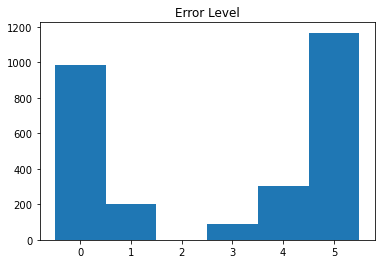

In [69]:
# Display a histogram of the error levels.
from pandas import DataFrame

# Apply a continuity correction to the range
r = [x - 1/2 for x in (0, Dimensions)]

df = DataFrame([s[2] for s in scores if not s[0]])
df.columns = ['Error Level']
df.hist(bins=Dimensions, grid=False, range=r)

#### Error Levels
0. Parse errors in the encoding
1. Difference of the surface form with the true surface form
2. Ungrammatical morpheme type combinations
3. Unparadigmatic morphemes
4. Difference in number of analytical words with the true form
5. Difference in morphemes with the true form